<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython.display import clear_output
!pip3 install --upgrade pystan
!pip3 install --upgrade fbprophet
clear_output()

In [3]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline

plt.rcParams['figure.figsize'] = (13, 7)

## Import monthly data

In [22]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

## Flag first full year of data

In [24]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

fl_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'),
                                                                     max_year=('date','max'))

fl_year['min_year'] = fl_year['min_year'].dt.year+1
fl_year['max_year'] = fl_year['max_year'].dt.year

df = pd.merge(df,fl_year,how='left',left_on=df.cd_estacao,right_on=min_year.index)

df.drop(columns='key_0', inplace=True)

df2009 = df[(df['min_year'] <= 2009) & (df['max_year'] >= 2020) & (df.date >= '2009-01-01')]

## Prophet

In [28]:
# preparing data for Prophet

strain = df2009.rename(columns={'date':'ds','chuva':'y'}).sort_values(['cd_estacao','ds']).reset_index(drop=True)

strain = strain[strain['ds']<='2019-12-01']

In [29]:
dict_model = {}
dff = pd.DataFrame([])

for cd_estacao in strain.cd_estacao.unique()[0:10]:
  m = Prophet()
  m.fit(strain[strain.cd_estacao == cd_estacao])
  dict_model[cd_estacao] = m
  future = m.make_future_dataframe(periods=12, freq='MS')
  forecast = m.predict(future)
  forecast['cd_estacao'] = cd_estacao
  dff = dff.append(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
m.plot()

A001
A002
A003
A005
A009
A010
A011
A012
A013
A014


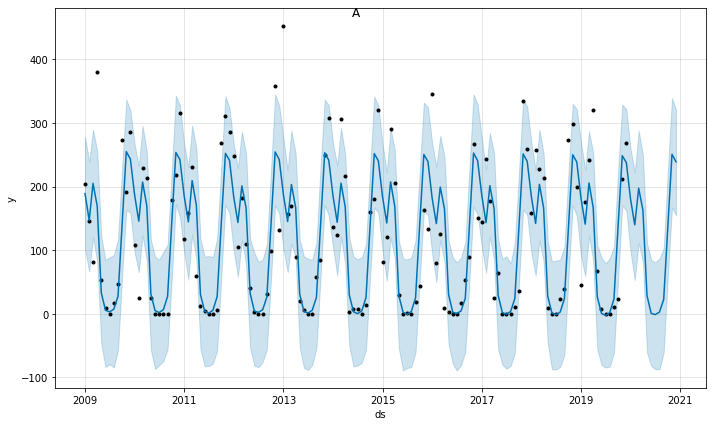

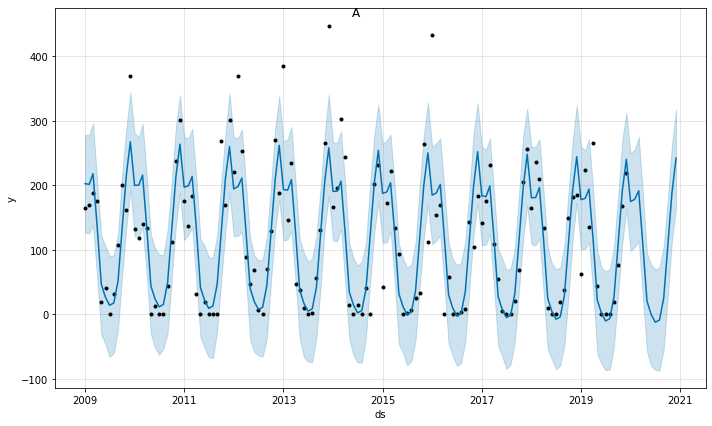

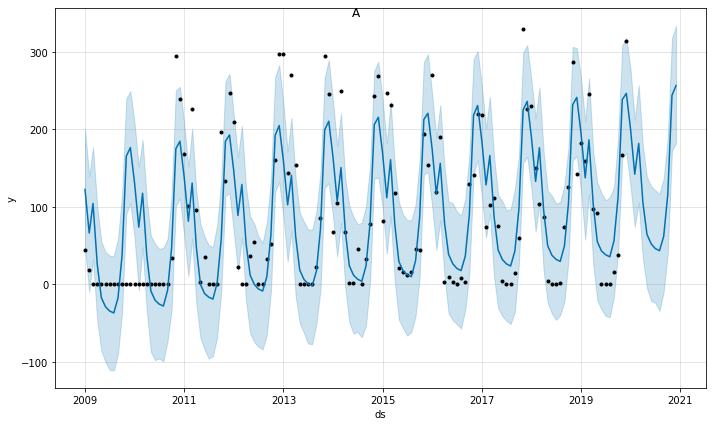

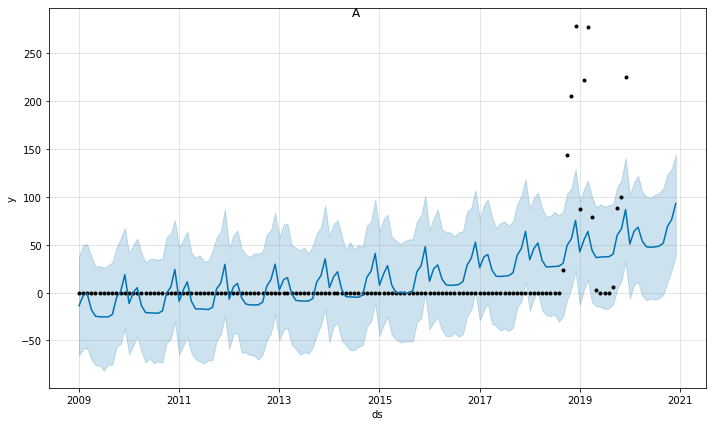

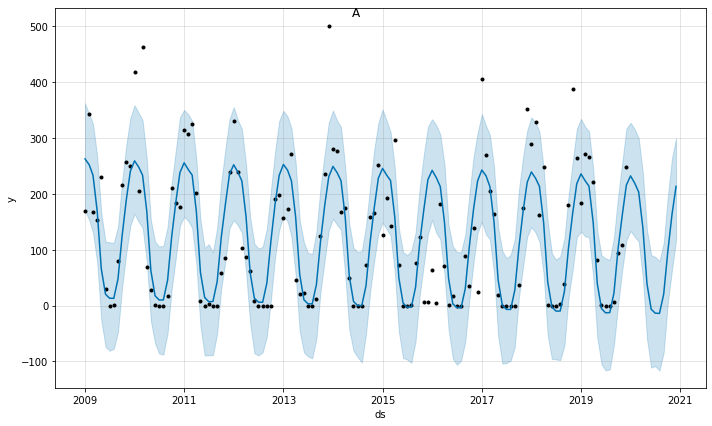

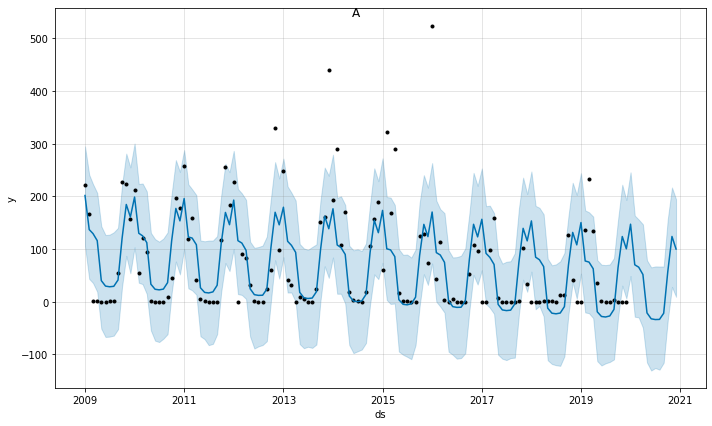

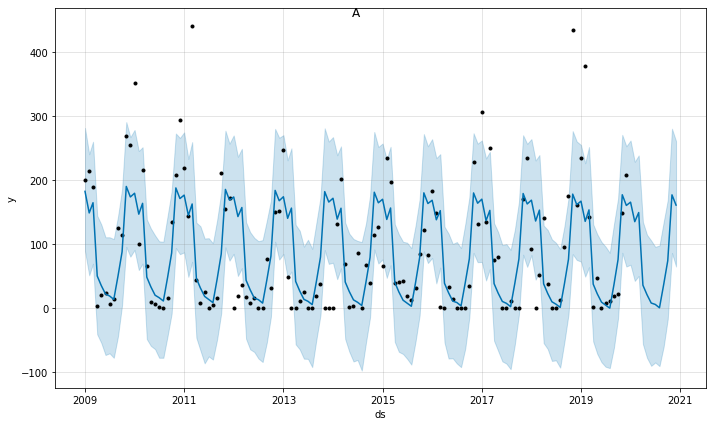

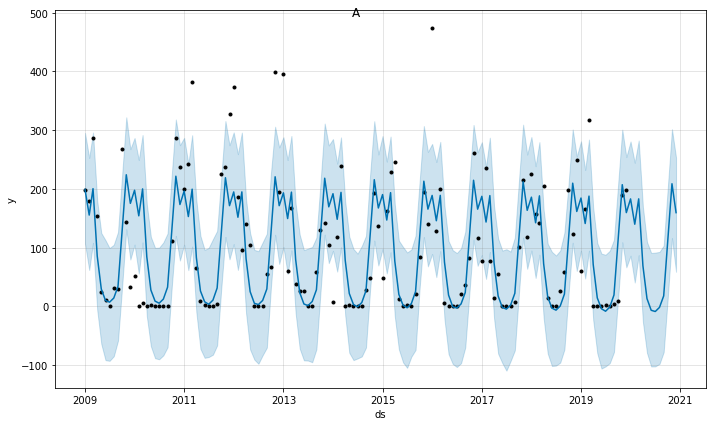

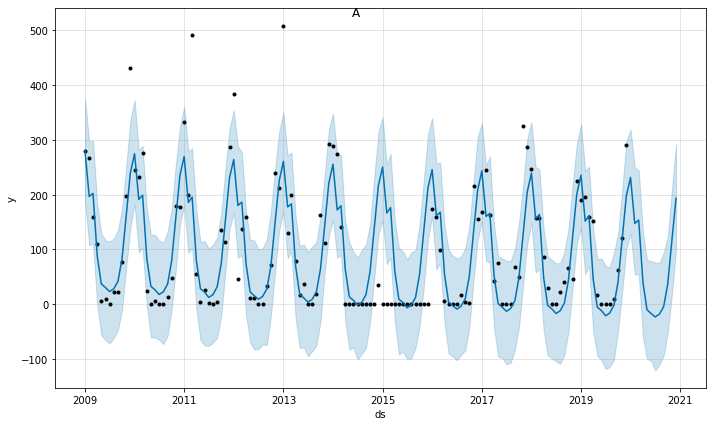

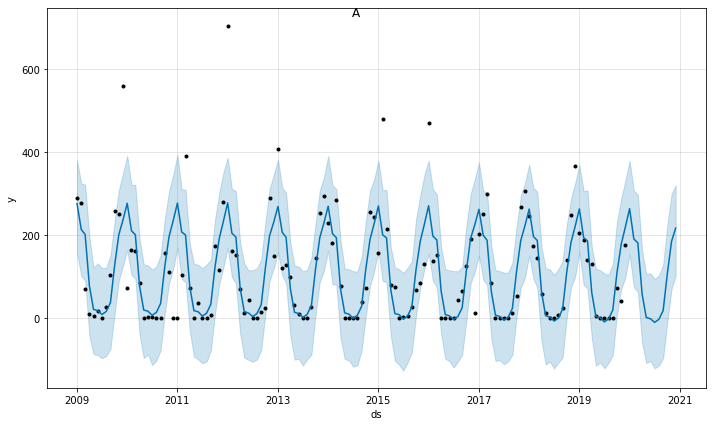

In [37]:
from fbprophet.plot import plot_plotly, plot_components_plotly

#plot_plotly(dict_model['A003'], dff[dff['cd_estacao']=='A003'])
for cd_estacao in dff.cd_estacao.unique():
  print(cd_estacao)
  fig = dict_model[cd_estacao].plot(dff[dff['cd_estacao']==cd_estacao])
  fig.suptitle('A')

In [ ]:
# Python
plot_components_plotly(m, forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df[(df.dc_nome=='sinop') & (df.index >= '2009-01-01')].chuva, pd.Series(forecast.yhat[:-1]).clip(0))

63.326747462030504

## Diagnosis

In [ ]:
from fbprophet.diagnostics import performance_metrics


In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='119 m', period='12 m', horizon='12 m')